In [43]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import os

mpl.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure1s/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    mpl.rcParams.update(new_rc_params)

In [2]:
from cooltools import numutils

In [3]:
# load cooler at 50kb resolution from the mcool
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
resolution = 25000
hic_cooler = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))

In [4]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep='\t')

if (hmm_track['end'].values[0]-hmm_track['start'].values[0]) !=  resolution: 
    raise ValueError('resolution mismatch, check files')

hmm_track.head()


,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,...,binary,HMM2,HMM3,HMM3P,HMM4,HMM5,HMM6,HMM7,HMM8,HMM9
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.019703,0.095678,NaN,0.351400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.004713,0.046797,NaN,0.402080,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.019023,0.094014,NaN,0.371200,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def intercompartmental_contacts(hmm_track, chrom, chrom_mat, compartment1, compartment2, annotation):
    chrom_track = hmm_track[hmm_track.chrom == chrom]
    comp_track1, comp_track2 = ((chrom_track[annotation] == compartment1).values, 
                                (chrom_track[annotation] == compartment2).values)
    compartment_contacts = chrom_mat[np.outer(comp_track1, comp_track2)]
    return compartment_contacts

In [6]:
chrom = 'chr19'
compartment1, compartment2 = 0, 4
annotation = 'HMM7'
chrom_mat = hic_cooler.matrix(balance=True).fetch(chrom)
compartment_contacts = intercompartmental_contacts(hmm_track, chrom, chrom_mat, compartment1, compartment2, annotation)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


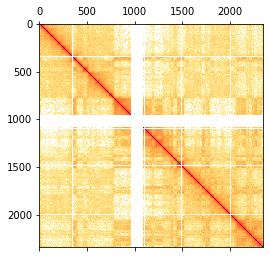

In [7]:
plt.matshow(np.log(chrom_mat), cmap='YlOrRd');

In [8]:
def nonzero_matrix(hmm_track, hic_cooler, annotation):
    annotation_max = int(np.nanmax(hmm_track[annotation]))
    result_mat = np.zeros((annotation_max+1, annotation_max+1))
    nonzero_mat = np.zeros((annotation_max+1, annotation_max+1))
    zero_mat = np.zeros((annotation_max+1, annotation_max+1))
    
    for chrom in hmm_track.chrom.unique():
        print(chrom)
        chrom_mat = hic_cooler.matrix(balance=True).fetch(chrom)
        
        for i in range(annotation_max+1):
            for j in range(annotation_max+1):
                if i>j:
                    continue

                compartment_contacts = intercompartmental_contacts(hmm_track, chrom, chrom_mat, i, j, annotation)
                zero_mat[i,j] = zero_mat[i,j] + (compartment_contacts==0).sum()
                nonzero_mat[i, j] = nonzero_mat[i, j] + (compartment_contacts>0).sum()
    
    nonzero_mat = nonzero_mat + nonzero_mat.T - np.diag(np.diag(nonzero_mat))
    zero_mat = zero_mat + zero_mat.T - np.diag(np.diag(zero_mat))
    result_mat = nonzero_mat/ (nonzero_mat+zero_mat)
    return result_mat

In [9]:
np.nanmax(chrom_mat)

0.4935737740754655

In [10]:
annotation = 'HMM3P'

result_mat = nonzero_matrix(hmm_track, hic_cooler, annotation)
result_mat

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


array([[0.72390663, 0.713444  , 0.69471293, 0.6324953 , 0.53165883],
       [0.713444  , 0.82652855, 0.79270998, 0.69424668, 0.71487033],
       [0.69471293, 0.79270998, 0.7923762 , 0.72759155, 0.73955051],
       [0.6324953 , 0.69424668, 0.72759155, 0.79072621, 0.74802879],
       [0.53165883, 0.71487033, 0.73955051, 0.74802879, 0.87747962]])

In [11]:
states_names = ['B', 'Mbb', 'M', 'Maa', 'A']

In [12]:
def plot_mat(mat, states_names):
    plt.figure(1, figsize=(5,5))
    plt.matshow(mat, cmap="bwr", fignum=1)
    ticks = np.arange(0, len(states_names), 1)
    plt.gca().set_yticks(ticks)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticklabels(states_names)
    plt.gca().set_xticklabels(states_names)
    plt.colorbar(shrink = .7)
    for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                text = plt.gca().text(j, i, str(int(mat[i, j])) + ' %',
                               ha="center", va="center", color="black")

In [ ]:
plot_mat(result_mat*100, states_names)
if saveFigs:
    plt.savefig(figure_path+'non

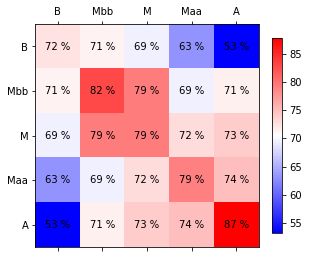

In [44]:
plot_mat(result_mat*100, states_names)
if saveFigs:
    plt.savefig(figure_path+'nonzero_counts'+'.svg', bbox_inches='tight')

In [14]:
def percentile_mats(hmm_track, hic_cooler, annotation):
    annotation_max = int(np.nanmax(hmm_track[annotation]))
    mat_50 = np.zeros((annotation_max+1, annotation_max+1))
    mat_25 = np.zeros((annotation_max+1, annotation_max+1))
    mat_75 = np.zeros((annotation_max+1, annotation_max+1))
    all_contacts = dict()
    
#     #Fill values
#     for i in range(annotation_max+1):
#         all_contact[i] = []*(annotation_max+1)
        
    
    for chrom in hmm_track.chrom.unique():
        print(chrom)
        chrom_mat = hic_cooler.matrix(balance=True).fetch(chrom)
        chrom_mat[~np.isfinite(chrom_mat)] = 0
        mask = chrom_mat.sum(axis=0) > 0
        chrom_mat, _, _, _ = numutils.observed_over_expected(chrom_mat, mask)
        
        for i in range(annotation_max+1):
            for j in range(annotation_max+1):
                if i>j:
                    continue

                compartment_contacts = intercompartmental_contacts(hmm_track, chrom, chrom_mat, i, j, annotation)
                all_contacts[i**2 + j**2] = all_contacts.get(i**2 + j**2, np.array([]))
                all_contacts[i**2 + j**2] = np.concatenate((all_contacts[i**2 + j**2], compartment_contacts))
#                 print(i, j, np.median(compartment_contacts))
                
    for i in range(annotation_max+1):
        for j in range(annotation_max+1):
            if i>j:
                continue
                
            mat_50[i, j] = np.percentile(all_contacts[i**2 + j**2], 50)
            mat_25[i, j] = np.percentile(all_contacts[i**2 + j**2], 25)
            mat_75[i, j] = np.percentile(all_contacts[i**2 + j**2], 75)
        
    
    mat_50 = mat_50 + mat_50.T - np.diag(np.diag(mat_50))
    mat_75 = mat_75 + mat_75.T - np.diag(np.diag(mat_75))
    mat_25 = mat_25 + mat_25.T - np.diag(np.diag(mat_25))
    
    return mat_25, mat_50, mat_75

In [34]:
def average_mat(hmm_track, hic_cooler, annotation):
    annotation_max = int(np.nanmax(hmm_track[annotation]))
    mean_mat = np.zeros((annotation_max+1, annotation_max+1))
    all_contacts = dict()
    
#     #Fill values
#     for i in range(annotation_max+1):
#         all_contact[i] = []*(annotation_max+1)
        
    
    for chrom in hmm_track.chrom.unique():
        print(chrom)
        chrom_mat = hic_cooler.matrix(balance=True).fetch(chrom)
        chrom_mat[~np.isfinite(chrom_mat)] = 0
        mask = chrom_mat.sum(axis=0) > 0
        chrom_mat, _, _, _ = numutils.observed_over_expected(chrom_mat, mask)
        
        for i in range(annotation_max+1):
            for j in range(annotation_max+1):
                if i>j:
                    continue

                compartment_contacts = intercompartmental_contacts(hmm_track, chrom, chrom_mat, i, j, annotation)
                all_contacts[i**2 + j**2] = all_contacts.get(i**2 + j**2, np.array([]))
                all_contacts[i**2 + j**2] = np.concatenate((all_contacts[i**2 + j**2], compartment_contacts))
#                 print(i, j, np.median(compartment_contacts))
                
    for i in range(annotation_max+1):
        for j in range(annotation_max+1):
            if i>j:
                continue
                
            mean_mat[i, j] = np.mean(all_contacts[i**2 + j**2])

        
    
    mean_mat = mean_mat + mean_mat.T - np.diag(np.diag(mean_mat))
    
    return mean_mat

In [15]:
hmm_track

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,...,binary,HMM2,HMM3,HMM3P,HMM4,HMM5,HMM6,HMM7,HMM8,HMM9
0,chr1,0,25000,NaN,0.002548,0.034406,NaN,0.573067,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,25000,50000,NaN,0.001826,0.029127,NaN,0.430960,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,50000,75000,NaN,0.019703,0.095678,NaN,0.351400,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,75000,100000,NaN,0.004713,0.046797,NaN,0.402080,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,100000,125000,NaN,0.019023,0.094014,NaN,0.371200,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115004,chr22,50700000,50725000,0.919536,1.621853,0.902310,0.003883,0.582120,-0.273457,0.576923,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0
115005,chr22,50725000,50750000,0.934506,1.581227,0.890937,0.003675,0.550640,-0.295694,0.546716,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0
115006,chr22,50750000,50775000,0.501871,0.752977,0.614810,0.006504,0.438000,-0.140475,0.489133,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0
115007,chr22,50775000,50800000,0.347564,0.453748,0.477263,0.009642,0.445800,-0.068095,0.510889,...,0.0,0.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,4.0


In [16]:
annotation = 'HMM3P'

mat_25, mat_50, mat_75 = percentile_mats(hmm_track, hic_cooler, annotation)
mat_25, mat_50, mat_75

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


(array([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.62037858, 0.48467944, 0.        , 0.        ],
        [0.        , 0.48467944, 0.48761485, 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.49027056, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.60924487]]),
 array([[1.3122732 , 0.91609956, 0.88707838, 0.74607073, 0.25706226],
        [0.91609956, 1.1445355 , 1.0934131 , 0.80290805, 0.69166435],
        [0.88707838, 1.0934131 , 1.07661687, 0.92504654, 0.73911017],
        [0.74607073, 0.80290805, 0.92504654, 1.11792151, 0.74496889],
        [0.25706226, 0.69166435, 0.73911017, 0.74496889, 1.07123063]]),
 array([[2.25631311, 1.60273633, 1.58287285, 1.50610324, 0.84690739],
        [1.60273633, 1.76685731, 1.71827599, 1.4251064 , 1.28176211],
        [1.58287285, 1.71827599, 1.68409797, 1.55520541, 1.30784138],
        [1.50610324, 1.4251064 , 1.55520541, 1.79320984, 1.3115213 ],
        [0.84690

In [35]:
annotation = 'HMM3P'

avg_mat = average_mat(hmm_track, hic_cooler, annotation)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [37]:
def plot_mat2(mat, states_names):
    plt.figure(1, figsize=(5,5))
#     flatmat = mat.reshape(-1)
#     _sort = np.argsort(flatmat)
    
# #     low, high =flatmat[_sort][4], flatmat[_sort][-4]
    cmap = mpl.cm.get_cmap("bwr").copy()
    cmap.set_bad('blue',1.)
    
    plt.matshow(mat, cmap=cmap, fignum=1, vmin=0.5, vmax=1.5)
    ticks = np.arange(0, len(states_names), 1)
    plt.gca().set_yticks(ticks)
    plt.gca().set_xticks(ticks)
    plt.gca().set_yticklabels(states_names)
    plt.gca().set_xticklabels(states_names)
    plt.colorbar(shrink = .5)
    for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                text = plt.gca().text(j, i, str(np.round(mat[i, j], 2)) ,
                               ha="center", va="center", color="black")

In [18]:
def full_median(hic_cooler, hmm_track):
    all_contacts = np.array([], dtype='float')
    for chrom in hmm_track.chrom.unique():
        print(chrom)
        mat = hic_cooler.matrix(balance=True).fetch(chrom)
        mat = mat[~np.isnan(mat)]
        all_contacts = np.concatenate((all_contacts,mat), axis=None)
        
    mat_median = np.median(all_contacts)
    return mat_median
    

In [19]:
mat_median = full_median(hic_cooler, hmm_track)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


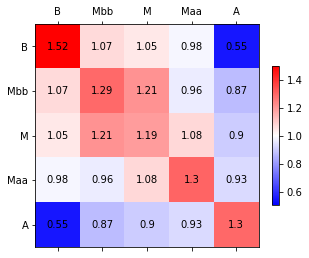

In [45]:
plot_mat2(avg_mat,states_names)
if saveFigs:
    plt.savefig(figure_path+'OE_counts_means'+'.svg', bbox_inches='tight')

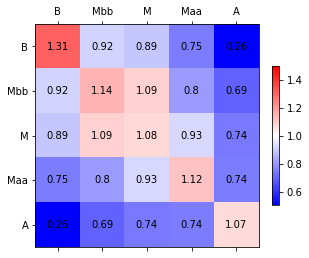

In [201]:
plot_mat2(mat_50,states_names)
if saveFigs:
    plt.savefig(figure_path+'OE_counts_medians'+'.svg', bbox_inches='tight')

In [321]:
chrom1,chrom2 = 'chr17', 'chr22'
chrom_track1 = hmm_track[hmm_track.chrom==chrom1]
chrom_track2 = hmm_track[hmm_track.chrom==chrom2]
chrom_mat = hic_cooler.matrix().fetch(chrom1, chrom2)
masked_mat = chrom_mat[~chrom_track1.E1.isna()][:, ~chrom_track2.E1.isna()]

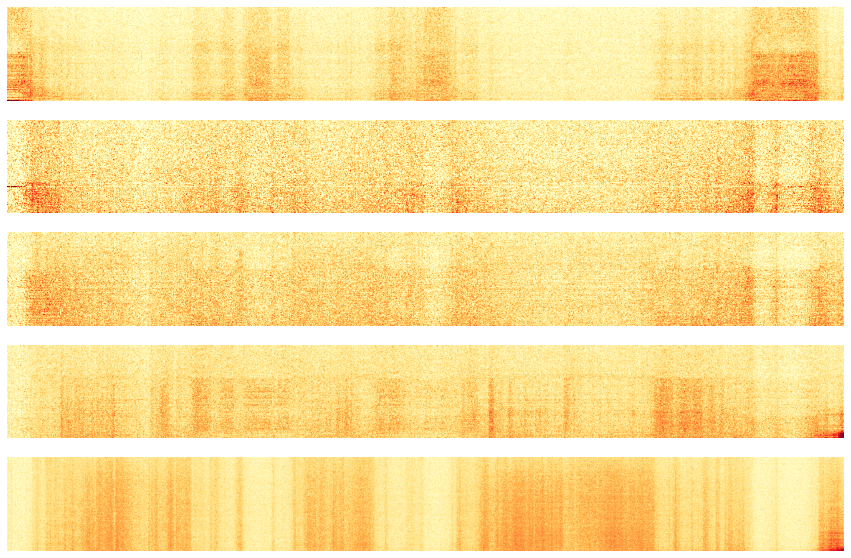

In [322]:
plt.figure(figsize=(15, 10))

min_val = 1e-5
max_val = np.percentile(masked_mat, 99)


for i in range(5):
    plt.subplot(5, 1, i+1)
    displayed_mat = chrom_mat[chrom_track1.HMM3P==i][:,~chrom_track2.E1.isna()].copy()
    sums = displayed_mat.sum(axis=1)
    order = np.argsort(sums)
    plt.imshow(np.log(displayed_mat[order]+min_val), cmap='YlOrRd', aspect='auto', vmin=np.log(min_val), vmax=np.log(2*max_val))
    plt.axis('off')
    
    
if saveFigs:
    plt.savefig(figure_path+'interchromsomal_patterns_'+chrom1+'_'+chrom2+'.svg', bbox_inches='tight')

In [1423]:
chrom = 'chr1'
chrom_track = hmm_track[hmm_track.chrom==chrom]
chrom_mat = hic_cooler.matrix().fetch(chrom)
mask = ~chrom_track.E1.isna().values
OE_mat, _, _, _ = numutils.observed_over_expected(chrom_mat, mask)
data = OE_mat[mask][:, mask].reshape(-1)

In [1424]:
np.min(np.percentile(data[data>0], 1))

0.21977690593520965

In [1442]:
OE_mat_clipped = OE_mat.copy()
OE_mat_clipped[OE_mat_clipped==0] = np.min(np.percentile(data[data>0], 1))
OE_masked = OE_mat_clipped[mask][:, mask].reshape(mask.sum(axis=0), mask.sum(axis=0))
# data = OE_masked.reshape(-1)
OE_masked = np.log2(OE_masked)

In [1426]:
# plt.hist(np.log2(data))

In [1427]:
def distance(a, b):
    d = (a-b)**2
    if len(d.shape)>1:
        return d.mean(axis=1)
    
    return d.mean()

In [ ]:
max_val = np.percentile(data, 95)

In [ ]:
min_val = np.percentile(data, 5)

In [ ]:
fig = plt.figure(figsize=(15, 10))
              
for i in range(5):
    plt.subplot(5, 1, i+1)
    displayed_mat = OE_mat[chrom_track.HMM3P==i][:,mask].copy()
#     displayed_mat = OE_masked[clusters[i]].copy()
#     displayed_mat = OE_masked[prediction==i].copy()
    print(displayed_mat.shape)
#     print(displayed_mat.shape) 
#     sums = displayed_mat.sum(axis=1)
    distances = distance(displayed_mat, displayed_mat[0])
    order = np.argsort(distances)
#     order = np.argsort(sums)
    im = plt.imshow(displayed_mat[order], cmap='bwr', aspect='auto', vmin=-2, vmax=2)
#     print(np.percentile(displayed_mat[order], 90))
    plt.axis('off')

    
cbar_ax = fig.add_axes([1.05, 0.2, 0.025, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, shrink = .7, label='Observed/Expected contacts')
    
# if saveFigs:
#     plt.savefig(figure_path+'intrachromsomal_patterns_'+chrom+'.svg', bbox_inches='tight')

(3165, 8857)
(963, 8857)
(985, 8857)
(922, 8857)
(2822, 8857)


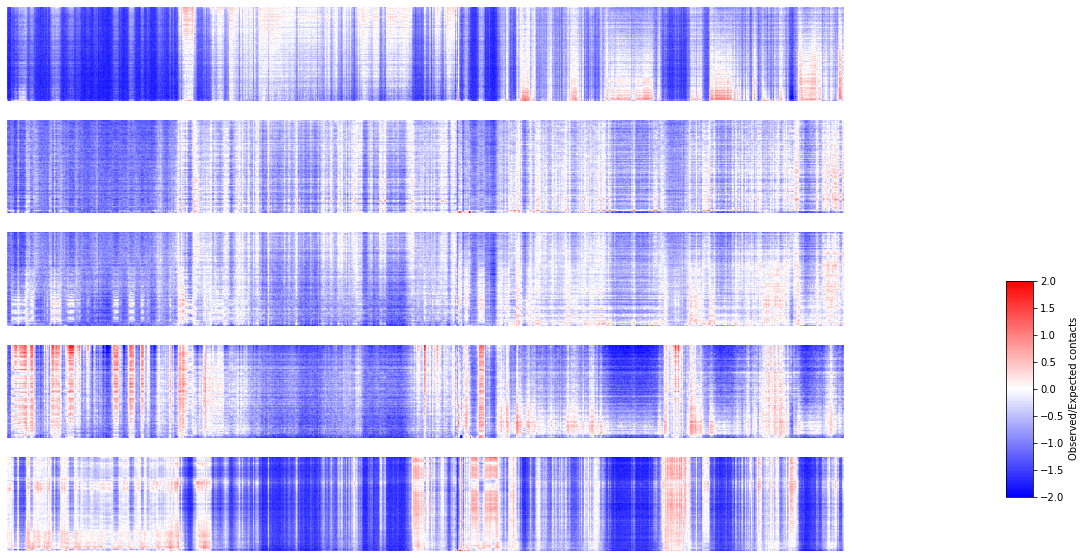

In [1446]:
fig = plt.figure(figsize=(15, 10))
              
for i in range(5):
    plt.subplot(5, 1, i+1)
    displayed_mat = OE_mat_clipped[chrom_track.HMM3P==i][:,mask].copy()
#     displayed_mat = OE_masked[clusters[i]].copy()
#     displayed_mat = OE_masked[prediction==i].copy()
    print(displayed_mat.shape)
#     print(displayed_mat.shape) 
#     sums = displayed_mat.sum(axis=1)
    distances = distance(displayed_mat, displayed_mat[0])
    order = np.argsort(distances)
#     order = np.argsort(sums)
    im = plt.imshow(np.log2(displayed_mat[order]), cmap='bwr', aspect='auto', vmin=-2, vmax=2)
#     print(np.percentile(displayed_mat[order], 90))
    plt.axis('off')

    
cbar_ax = fig.add_axes([1.05, 0.2, 0.025, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax, shrink = .7, label='Observed/Expected contacts')
    
# if saveFigs:
#     plt.savefig(figure_path+'intrachromsomal_patterns_'+chrom+'.svg', bbox_inches='tight')

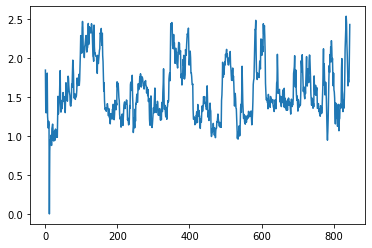

In [1328]:
plt.plot(distances)

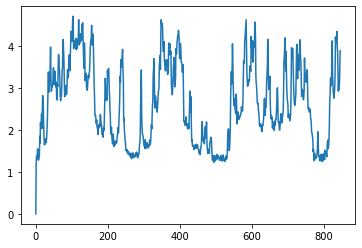

In [1325]:
plt.plot(distances)